In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,precision_score,accuracy_score,classification_report, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [7]:
df = pd.read_csv('secom_cleaned.csv')

In [8]:
labels =df['label']
df = df.drop(['label'], axis=1)

### Scaling of Data

In [9]:
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df)
pca = PCA(n_components=0.95)
df = pca.fit_transform(df)
df = pd.DataFrame(df)
# Add the labels back to the data
df['label'] = labels
print("No.of columns in the Dataset:", len(df.columns))

No.of columns in the Dataset: 150


## Data Preprocessing for Training

In [5]:
# Data Preprocessing
df_normal = df[df['label'] == -1]
df_anomalous = df[df['label'] == 1]
df_normal = df_normal.drop(columns=['label'])
df_anomalous = df_anomalous.drop(columns=['label'])
# Data Distribution
print(f"Normal: {len(df_normal)}, Anomalous: {len(df_anomalous)}")

Normal: 1463, Anomalous: 104


## Training and Evaluation of the Model
- Manual hyperparameter tuning was performed due to the nature of the model and data.  
- Different hyperparameter values were tested, and the best ones were selected based on training loss, validation loss, accuracy, F1-score, and precision.  
- The following results correspond to the model trained with the best hyperparameters.  
- **K-fold cross-validation** was used to ensure the model was trained on different subsets of the data. Since only a subset of the normal class was used for testing, relying on a single split might not provide the most reliable results. K-fold cross-validation helps mitigate this issue by training the model across multiple data folds, leading to a more robust evaluation.
- Plots to verify how the model performed during training and validation.
- Plots for Training Loss Curve
- Plots for Distribution of Predicitons Scores in Training, Test Normal, and Test Anomalous Data

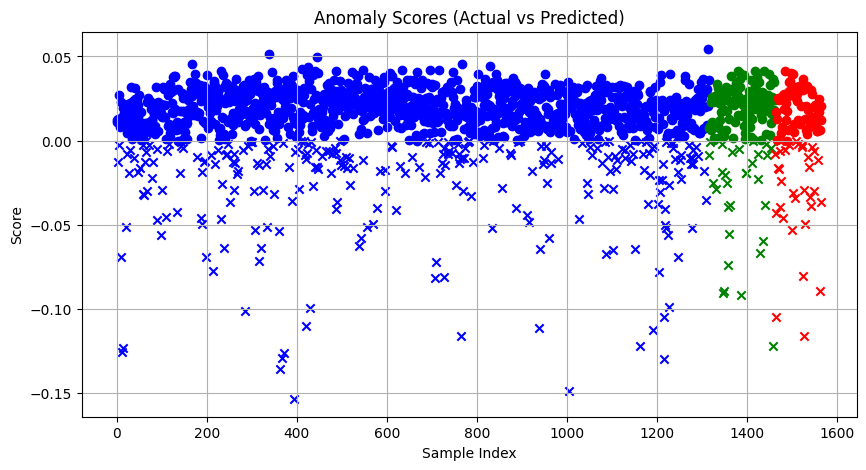

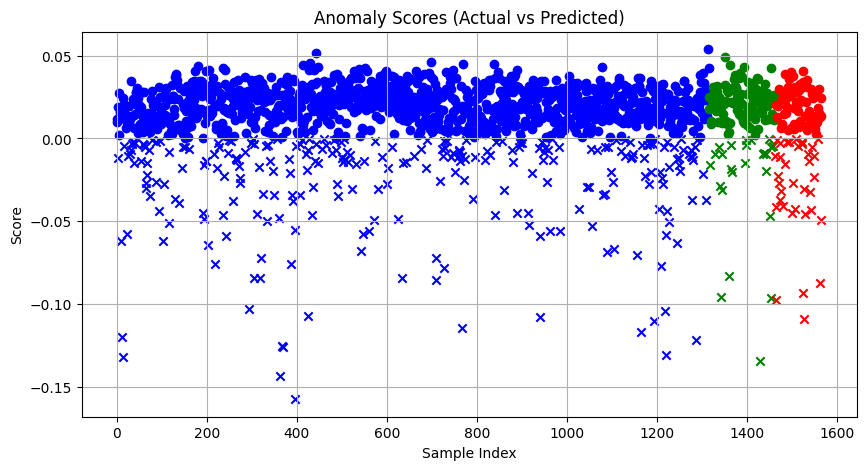

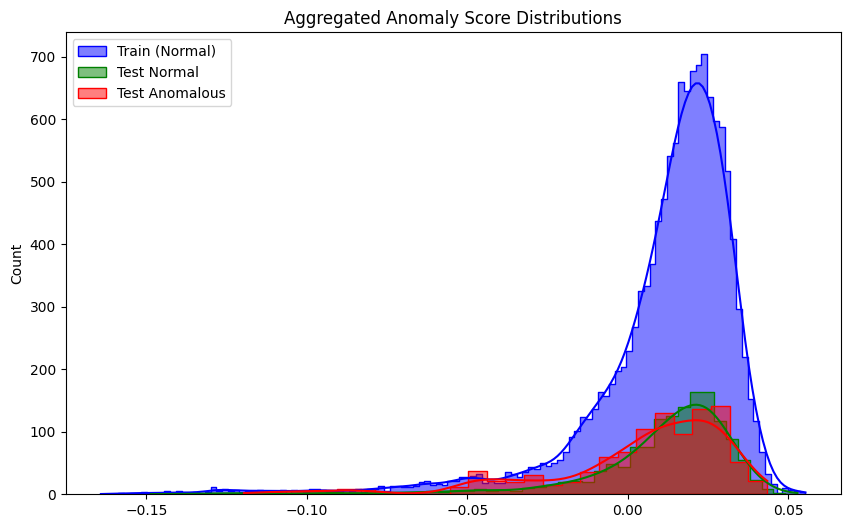

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70      1463
         1.0       0.54      0.32      0.40      1040

    accuracy                           0.60      2503
   macro avg       0.58      0.56      0.55      2503
weighted avg       0.59      0.60      0.58      2503


Train Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89     13167
         1.0       0.00      0.00      0.00         0

    accuracy                           0.80     13167
   macro avg       0.50      0.40      0.44     13167
weighted avg       1.00      0.80      0.89     13167



In [6]:
# Initialize lists to store scores and labels and losses for each fold
train_scores = []
test_scores = []
test_labels = []

all_y_test = []
all_y_pred = []

all_y_pred_train = []
all_y_test_train = []

# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
#defining n to print certain folds into the graph
n = 0
# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    n = n + 1
    
    # Data preparation
    X_train = df_normal.iloc[train_index]
    X_test_normal = df_normal.iloc[test_index]
    
    # Create test set with anomalies
    X_test = pd.concat([X_test_normal, df_anomalous])
    y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(df_anomalous))])
    
    # Train the Model
    model = IsolationForest(contamination=0.2, random_state=42, n_jobs=-1, n_estimators=900, max_features=0.1)
    model.fit(X_train)
    
    # Get anomaly scores
    train_score = model.decision_function(X_train)
    test_score = model.decision_function(X_test)
    
    # Split test scores into normal and anomalous parts
    test_score_normal = test_score[:len(X_test_normal)]
    test_score_anomalous = test_score[len(X_test_normal):]
    
    # Store scores for aggregate analysis
    train_scores.extend(train_score)
    test_scores.extend(test_score_normal)
    test_scores.extend(test_score_anomalous)
    test_labels.extend([0]*len(test_score_normal))
    test_labels.extend([1]*len(test_score_anomalous))
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    y_pred_train = model.predict(X_train)
    y_pred_train = [1 if x == -1 else 0 for x in y_pred_train]
    
    # Collect classification data
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_train.extend(y_pred_train)
    all_y_test_train.extend(np.zeros(len(X_train)))
    
    if n<=2:# only print the first 2 folds for graphical representation
        # Plot anomaly scores with actual vs predicted
        plt.figure(figsize=(10, 5))
        # Training data (actual normal => color blue), marker based on predicted label
        train_markers = ['o' if p == 0 else 'x' for p in y_pred_train]
        for i in range(len(X_train)):
            plt.scatter(i, train_score[i], color='blue', marker=train_markers[i])

        # Test data (color depends on actual label; marker depends on predicted label)
        for i in range(len(X_test)):
            color = 'green' if y_test[i] == 0 else 'red'
            marker = 'o' if y_pred[i] == 0 else 'x'
            plt.scatter(i + len(X_train), test_score[i], color=color, marker=marker)

        plt.title("Anomaly Scores (Actual vs Predicted)")
        plt.xlabel("Sample Index")
        plt.ylabel("Score")
        plt.grid(True)
        plt.show()

# Aggregate histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(train_scores, color='blue', label='Train (Normal)', kde=True, element='step')
sns.histplot([s for s, l in zip(test_scores, test_labels) if l == 0], 
             color='green', label='Test Normal', kde=True, element='step')
sns.histplot([s for s, l in zip(test_scores, test_labels) if l == 1], 
             color='red', label='Test Anomalous', kde=True, element='step')
plt.legend()
plt.title('Aggregated Anomaly Score Distributions')
plt.show()

# Classification reports
print("Test Classification Report:")
print(classification_report(all_y_test, all_y_pred))

print("\nTrain Classification Report:")
print(classification_report(all_y_test_train, all_y_pred_train))